Preparing data for semantic segmentation
===

In [3]:
# Download Data
# CamVid Dataset: http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/
!git clone https://github.com/alexgkendall/SegNet-Tutorial tmp/

Cloning into 'tmp'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785 (from 1)
Receiving objects: 100% (2785/2785), 340.84 MiB | 34.28 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [21]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from loguru import logger

In [2]:
CLASS_NAMES = [
    "sky", "building", "pole", "road", "pavement",
    "tree", "signsymbol", "fence", "car",
    "pedestrian", "bicyclist", "background"
]
# original class mapping => background: 11

# we need to change that to:
# background: 0
class_map = {
    i: (i+1 if cls != "background" else 0)
    for i, cls in enumerate(CLASS_NAMES)
}

class_map

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 0}

In [23]:
root_orig_dir = "tmp/CamVid/"

img_train_dir = os.path.join(root_orig_dir, "train")
img_val_dir = os.path.join(root_orig_dir, "val")
img_test_dir = os.path.join(root_orig_dir, "test")
mask_train_dir = os.path.join(root_orig_dir, "trainannot")
mask_val_dir = os.path.join(root_orig_dir, "valannot")
mask_test_dir = os.path.join(root_orig_dir, "testannot")

list_train_samples = [(f, "train") for f in os.listdir(img_train_dir)]
list_val_samples = [(f, "val") for f in os.listdir(img_val_dir)]
list_test_samples = [(f, "test") for f in os.listdir(img_test_dir)]
list_orig_samples = list_train_samples + list_val_samples + list_test_samples

logger.info(f"{len(list_train_samples)} training images")
logger.info(f"{len(list_val_samples)} validation images")
logger.info(f"{len(list_test_samples)} test images")

2024-10-04 22:50:14.642 | INFO     | __main__:<module>:15 - 367 training images
2024-10-04 22:50:14.642 | INFO     | __main__:<module>:16 - 101 validation images
2024-10-04 22:50:14.643 | INFO     | __main__:<module>:17 - 233 test images


In [24]:
root_prep_dir = "data/"
images_dir = os.path.join(root_prep_dir, "images")
masks_dir = os.path.join(root_prep_dir, "masks")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

list_prep_samples = []
for filename, split in list_orig_samples:
    if split == "train":
        img_path = os.path.join(img_train_dir, filename)
        mask_path = os.path.join(mask_train_dir, filename)
    elif split == "val":
        img_path = os.path.join(img_val_dir, filename)
        mask_path = os.path.join(mask_val_dir, filename)
    elif split == "test":
        img_path = os.path.join(img_test_dir, filename)
        mask_path = os.path.join(mask_test_dir, filename)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # remap classes
    mask = np.vectorize(class_map.get)(mask)
    
    img_path = os.path.join(images_dir, filename.replace(".png", ".jpg"))
    mask_path = os.path.join(masks_dir, filename)
    cv2.imwrite(img_path, img)
    cv2.imwrite(mask_path, mask)

    list_prep_samples.append({
        "imagepath": img_path,
        "maskpath": mask_path,
        "split": split
    })


df = pd.DataFrame(list_prep_samples)

In [25]:
df.head()

,imagepath,maskpath,split
0,data/images/0016E5_07170.jpg,data/masks/0016E5_07170.png,train
1,data/images/0006R0_f02850.jpg,data/masks/0006R0_f02850.png,train
2,data/images/0006R0_f02310.jpg,data/masks/0006R0_f02310.png,train
3,data/images/0006R0_f03390.jpg,data/masks/0006R0_f03390.png,train
4,data/images/0006R0_f02670.jpg,data/masks/0006R0_f02670.png,train


<Axes: xlabel='split'>

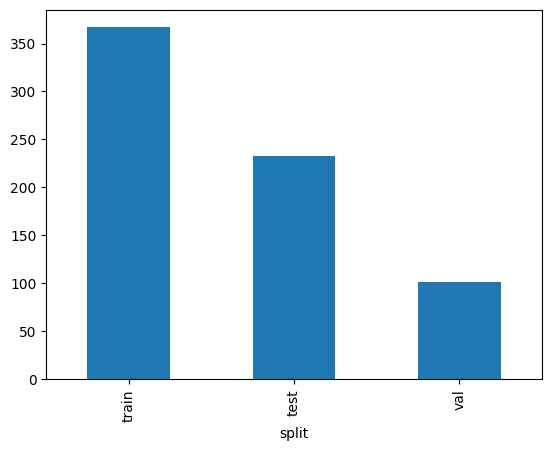

In [27]:
# histogram of splits
df["split"].value_counts().plot(kind="bar")

In [28]:
df.to_csv(os.path.join(root_prep_dir, "data.csv"), index=False)

In [31]:
# remove the tmp directory
!rm -rf tmp/